# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


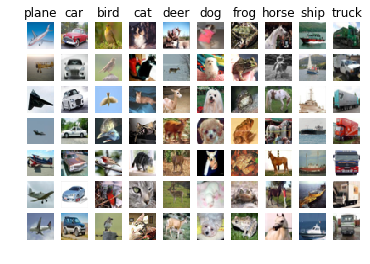

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


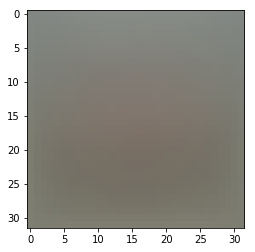

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.382306


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -25.075992 analytic: -25.075992, relative error: 1.191518e-11
numerical: -7.609063 analytic: -7.609063, relative error: 2.057828e-11
numerical: 2.780910 analytic: 2.780910, relative error: 2.657387e-11
numerical: 2.203272 analytic: 2.302516, relative error: 2.202595e-02
numerical: -2.732241 analytic: -2.732241, relative error: 9.253699e-12
numerical: 13.473294 analytic: 13.473294, relative error: 2.226541e-11
numerical: -13.510888 analytic: -13.510888, relative error: 1.361881e-11
numerical: 1.661395 analytic: 1.661395, relative error: 2.574259e-10
numerical: -40.430238 analytic: -40.430238, relative error: 3.425277e-13
numerical: 21.057456 analytic: 21.055334, relative error: 5.039682e-05
numerical: 8.583603 analytic: 8.631991, relative error: 2.810674e-03
numerical: -17.847266 analytic: -17.847266, relative error: 1.707266e-11
numerical: -7.648760 analytic: -7.648760, relative error: 3.601921e-11
numerical: 8.753335 analytic: 8.753335, relative error: 1.263726e-11
numerica

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [10]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.382306e+00 computed in 0.359438s
Vectorized loss: 9.382306e+00 computed in 0.036296s
difference: 0.000000


In [11]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.294849s
Vectorized loss and gradient: computed in 0.025911s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [21]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 21.310268
iteration 100 / 1500: loss 9.126645
iteration 200 / 1500: loss 10.086338
iteration 300 / 1500: loss 7.801768
iteration 400 / 1500: loss 8.435842
iteration 500 / 1500: loss 8.439217
iteration 600 / 1500: loss 7.082809
iteration 700 / 1500: loss 7.583444
iteration 800 / 1500: loss 7.378655
iteration 900 / 1500: loss 7.142100
iteration 1000 / 1500: loss 6.290961
iteration 1100 / 1500: loss 6.769261
iteration 1200 / 1500: loss 6.274402
iteration 1300 / 1500: loss 6.691429
iteration 1400 / 1500: loss 6.127823
That took 17.361764s


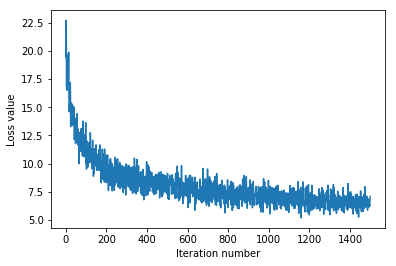

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.304592
validation accuracy: 0.313000


In [43]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [5e-7, 8e-7, 1e-6]
regularization_strengths = [2e4,2.5e4, 5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

def run_svm(lr, reg, num_iters=5000):
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                           num_iters=num_iters, verbose=True)
    y_train_pred = svm.predict(X_train)
    train_acc = np.mean(y_train == y_train_pred)
    #print('training accuracy: %f' % (train_acc, ))
    y_val_pred = svm.predict(X_val)
    val_acc = np.mean(y_val == y_val_pred)
    print('lr: {}, reg: {}, train_acc: {}, valid_acc: {}'.format(lr, reg, train_acc, val_acc, ))
    return train_acc, val_acc, svm

num_iteration_pool =[2000,5000, 6000]

import itertools
for lr, reg,num_iter in itertools.product(learning_rates, regularization_strengths, num_iteration_pool):
    train_acc, val_acc, svm = run_svm(lr, reg, num_iter)
    results[(lr,reg)] = (train_acc, val_acc)
    if val_acc > best_val:
        best_val = val_acc
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 20.928485
iteration 100 / 2000: loss 8.108283
iteration 200 / 2000: loss 7.953233
iteration 300 / 2000: loss 5.865530
iteration 400 / 2000: loss 6.504169
iteration 500 / 2000: loss 5.738824
iteration 600 / 2000: loss 5.465894
iteration 700 / 2000: loss 5.539354
iteration 800 / 2000: loss 6.078288
iteration 900 / 2000: loss 4.976152
iteration 1000 / 2000: loss 5.635259
iteration 1100 / 2000: loss 4.754914
iteration 1200 / 2000: loss 4.723941
iteration 1300 / 2000: loss 4.779573
iteration 1400 / 2000: loss 4.869021
iteration 1500 / 2000: loss 5.967893
iteration 1600 / 2000: loss 5.193131
iteration 1700 / 2000: loss 4.615507
iteration 1800 / 2000: loss 4.378650
iteration 1900 / 2000: loss 4.235833
lr: 5e-07, reg: 20000.0, train_acc: 0.36881632653061225, valid_acc: 0.363
iteration 0 / 5000: loss 21.175394
iteration 100 / 5000: loss 7.283863
iteration 200 / 5000: loss 7.266428
iteration 300 / 5000: loss 6.603758
iteration 400 / 5000: loss 6.601344
iteration 500 / 50

iteration 1400 / 6000: loss 5.328477
iteration 1500 / 6000: loss 4.889788
iteration 1600 / 6000: loss 4.879031
iteration 1700 / 6000: loss 4.747969
iteration 1800 / 6000: loss 5.010450
iteration 1900 / 6000: loss 5.367004
iteration 2000 / 6000: loss 4.523436
iteration 2100 / 6000: loss 5.104695
iteration 2200 / 6000: loss 5.621013
iteration 2300 / 6000: loss 4.624196
iteration 2400 / 6000: loss 4.507197
iteration 2500 / 6000: loss 4.796277
iteration 2600 / 6000: loss 4.188314
iteration 2700 / 6000: loss 5.053384
iteration 2800 / 6000: loss 4.119023
iteration 2900 / 6000: loss 4.244079
iteration 3000 / 6000: loss 4.872089
iteration 3100 / 6000: loss 3.866877
iteration 3200 / 6000: loss 4.396013
iteration 3300 / 6000: loss 5.634901
iteration 3400 / 6000: loss 3.966969
iteration 3500 / 6000: loss 4.012107
iteration 3600 / 6000: loss 4.753144
iteration 3700 / 6000: loss 4.610966
iteration 3800 / 6000: loss 4.621683
iteration 3900 / 6000: loss 4.789831
iteration 4000 / 6000: loss 4.358176
i

iteration 1700 / 5000: loss 5.030749
iteration 1800 / 5000: loss 4.493825
iteration 1900 / 5000: loss 4.940262
iteration 2000 / 5000: loss 4.371986
iteration 2100 / 5000: loss 5.094192
iteration 2200 / 5000: loss 4.748584
iteration 2300 / 5000: loss 5.244043
iteration 2400 / 5000: loss 4.042078
iteration 2500 / 5000: loss 5.129207
iteration 2600 / 5000: loss 4.642157
iteration 2700 / 5000: loss 5.079558
iteration 2800 / 5000: loss 4.944086
iteration 2900 / 5000: loss 4.514615
iteration 3000 / 5000: loss 4.486483
iteration 3100 / 5000: loss 4.205442
iteration 3200 / 5000: loss 4.999224
iteration 3300 / 5000: loss 4.080384
iteration 3400 / 5000: loss 5.227804
iteration 3500 / 5000: loss 4.066003
iteration 3600 / 5000: loss 4.306868
iteration 3700 / 5000: loss 4.240274
iteration 3800 / 5000: loss 4.788244
iteration 3900 / 5000: loss 5.405262
iteration 4000 / 5000: loss 4.578474
iteration 4100 / 5000: loss 4.669129
iteration 4200 / 5000: loss 4.437858
iteration 4300 / 5000: loss 4.444243
i

iteration 5200 / 6000: loss 4.294900
iteration 5300 / 6000: loss 4.836754
iteration 5400 / 6000: loss 4.760975
iteration 5500 / 6000: loss 4.202098
iteration 5600 / 6000: loss 3.846027
iteration 5700 / 6000: loss 4.787497
iteration 5800 / 6000: loss 4.301938
iteration 5900 / 6000: loss 4.466598
lr: 8e-07, reg: 20000.0, train_acc: 0.38273469387755105, valid_acc: 0.358
iteration 0 / 2000: loss 17.110064
iteration 100 / 2000: loss 7.108154
iteration 200 / 2000: loss 7.035821
iteration 300 / 2000: loss 6.557196
iteration 400 / 2000: loss 5.920070
iteration 500 / 2000: loss 6.014637
iteration 600 / 2000: loss 5.836891
iteration 700 / 2000: loss 5.702211
iteration 800 / 2000: loss 5.466154
iteration 900 / 2000: loss 5.716013
iteration 1000 / 2000: loss 5.385318
iteration 1100 / 2000: loss 5.417936
iteration 1200 / 2000: loss 4.117942
iteration 1300 / 2000: loss 5.848056
iteration 1400 / 2000: loss 4.150621
iteration 1500 / 2000: loss 3.934384
iteration 1600 / 2000: loss 5.768938
iteration 17

iteration 400 / 6000: loss 6.008936
iteration 500 / 6000: loss 5.585549
iteration 600 / 6000: loss 6.286349
iteration 700 / 6000: loss 5.313033
iteration 800 / 6000: loss 5.469181
iteration 900 / 6000: loss 5.308884
iteration 1000 / 6000: loss 4.804644
iteration 1100 / 6000: loss 5.993998
iteration 1200 / 6000: loss 5.182551
iteration 1300 / 6000: loss 4.300971
iteration 1400 / 6000: loss 4.833638
iteration 1500 / 6000: loss 5.144497
iteration 1600 / 6000: loss 4.979222
iteration 1700 / 6000: loss 5.641938
iteration 1800 / 6000: loss 4.820567
iteration 1900 / 6000: loss 4.373391
iteration 2000 / 6000: loss 4.762010
iteration 2100 / 6000: loss 5.051420
iteration 2200 / 6000: loss 4.799051
iteration 2300 / 6000: loss 5.438786
iteration 2400 / 6000: loss 4.652330
iteration 2500 / 6000: loss 4.751042
iteration 2600 / 6000: loss 4.726297
iteration 2700 / 6000: loss 4.490526
iteration 2800 / 6000: loss 4.726179
iteration 2900 / 6000: loss 5.062473
iteration 3000 / 6000: loss 3.961793
iterati

iteration 700 / 5000: loss 5.271017
iteration 800 / 5000: loss 4.870193
iteration 900 / 5000: loss 4.785810
iteration 1000 / 5000: loss 4.971940
iteration 1100 / 5000: loss 5.029836
iteration 1200 / 5000: loss 4.775569
iteration 1300 / 5000: loss 4.432843
iteration 1400 / 5000: loss 4.063398
iteration 1500 / 5000: loss 5.079625
iteration 1600 / 5000: loss 4.879614
iteration 1700 / 5000: loss 5.143414
iteration 1800 / 5000: loss 5.468116
iteration 1900 / 5000: loss 4.156680
iteration 2000 / 5000: loss 4.906352
iteration 2100 / 5000: loss 4.256535
iteration 2200 / 5000: loss 4.801095
iteration 2300 / 5000: loss 4.540951
iteration 2400 / 5000: loss 4.888430
iteration 2500 / 5000: loss 5.173573
iteration 2600 / 5000: loss 5.198428
iteration 2700 / 5000: loss 5.618877
iteration 2800 / 5000: loss 4.391578
iteration 2900 / 5000: loss 4.117317
iteration 3000 / 5000: loss 4.231813
iteration 3100 / 5000: loss 4.164731
iteration 3200 / 5000: loss 4.805012
iteration 3300 / 5000: loss 4.648783
iter

iteration 4200 / 6000: loss 3.723634
iteration 4300 / 6000: loss 4.701379
iteration 4400 / 6000: loss 4.394342
iteration 4500 / 6000: loss 4.153012
iteration 4600 / 6000: loss 4.382093
iteration 4700 / 6000: loss 4.348781
iteration 4800 / 6000: loss 4.586547
iteration 4900 / 6000: loss 6.199212
iteration 5000 / 6000: loss 4.831701
iteration 5100 / 6000: loss 4.523673
iteration 5200 / 6000: loss 4.692020
iteration 5300 / 6000: loss 4.571508
iteration 5400 / 6000: loss 4.965374
iteration 5500 / 6000: loss 5.142568
iteration 5600 / 6000: loss 4.418031
iteration 5700 / 6000: loss 4.774093
iteration 5800 / 6000: loss 4.921230
iteration 5900 / 6000: loss 4.702033
lr: 1e-06, reg: 25000.0, train_acc: 0.3896734693877551, valid_acc: 0.38
iteration 0 / 2000: loss 25.415245
iteration 100 / 2000: loss 8.624564
iteration 200 / 2000: loss 6.397557
iteration 300 / 2000: loss 5.804727
iteration 400 / 2000: loss 6.535249
iteration 500 / 2000: loss 5.911103
iteration 600 / 2000: loss 5.017325
iteration 7

iteration 4600 / 5000: loss 4.171914
iteration 4700 / 5000: loss 4.472764
iteration 4800 / 5000: loss 4.596379
iteration 4900 / 5000: loss 4.419686
lr: 1e-06, reg: 100000.0, train_acc: 0.3882244897959184, valid_acc: 0.365
iteration 0 / 6000: loss 22.241574
iteration 100 / 6000: loss 7.541726
iteration 200 / 6000: loss 6.391190
iteration 300 / 6000: loss 6.375826
iteration 400 / 6000: loss 5.736277
iteration 500 / 6000: loss 5.415933
iteration 600 / 6000: loss 5.741815
iteration 700 / 6000: loss 5.644710
iteration 800 / 6000: loss 5.550220
iteration 900 / 6000: loss 4.764801
iteration 1000 / 6000: loss 5.409444
iteration 1100 / 6000: loss 4.638868
iteration 1200 / 6000: loss 5.747450
iteration 1300 / 6000: loss 4.123796
iteration 1400 / 6000: loss 4.613906
iteration 1500 / 6000: loss 4.870062
iteration 1600 / 6000: loss 5.438764
iteration 1700 / 6000: loss 5.887578
iteration 1800 / 6000: loss 4.975120
iteration 1900 / 6000: loss 4.575827
iteration 2000 / 6000: loss 4.964481
iteration 21

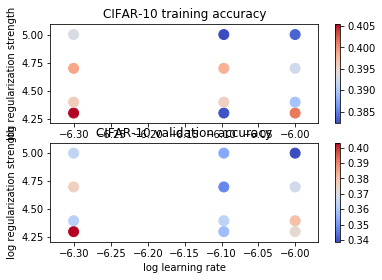

In [44]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [45]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.363000


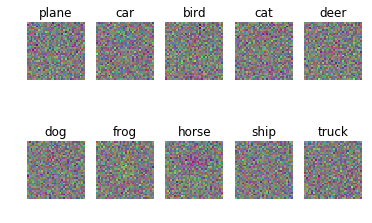

In [46]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
